In [1]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt

## Load data

In [2]:
# Copy results of NF here
import subprocess

subprocess.run(["cp", "/Users/katianakontolati/PycharmProjects/pytorch-flows/results/results.npz", "data/"])
#subprocess.run(["cp", "/Users/katianakontolati/Documents/Johns Hopkins University/1.PhD/LANL-Research/Research/ChemCam_data/Mixed_data/NF_mixed_train_test_data.npz", "data/"])
#subprocess.run(["cp", "/Users/katianakontolati/Documents/Johns Hopkins University/1.PhD/LANL-Research/Research/ChemCam_data/calibration_data/calibration_data.npz", "data/"])

CompletedProcess(args=['cp', '/Users/katianakontolati/PycharmProjects/pytorch-flows/results/results.npz', 'data/'], returncode=0)

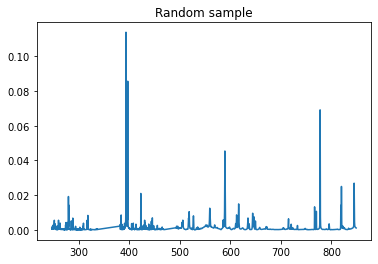

(426, 5606)

In [3]:
# Get calibration samples and labels 

# Load observations
file = np.load('data/NF_mixed_train_test_data.npz')  
calib_data = file['y_calib'] # get earth data after earth_2_mars transform

# Load wavelengths
w = file['w']
plt.plot(w, calib_data[0,:])
plt.title('Random sample')
plt.show()
calib_data.shape

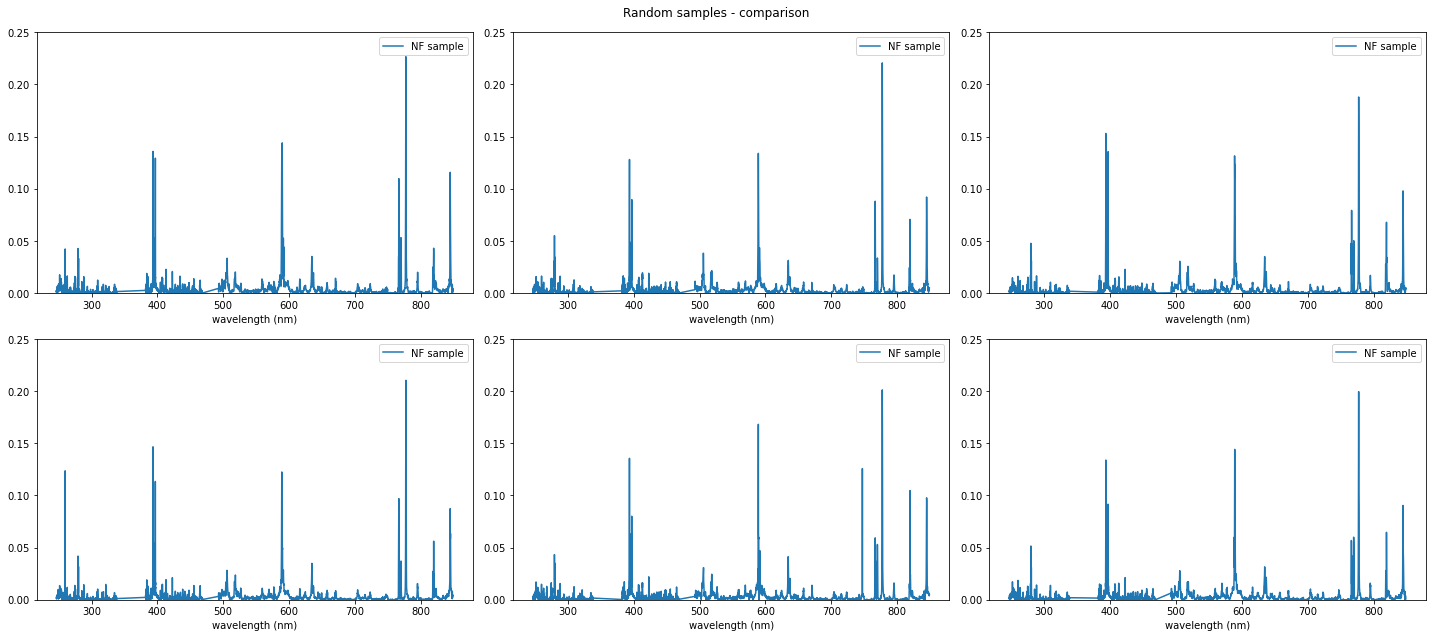

In [4]:
# Load results from NF training
file1 = np.load('data/results.npz') 
calib_data_gaussian = file1['z'] # load calibration data to gaussian (X --> Z)

# Load noise and corresponding LIBS spectra (Z --> X)
noise = file1['noise']
libs_from_noise = file1['forward_flow']

# Plot samples in two random dimensions
#plt.scatter(calib_data_gaussian[:,1], calib_data_gaussian[:,2]) # notice a few outliers
#plt.show()

# Compare an original LIBS sample with one generated with the NF model
# Plot before normalization
fig = plt.figure(figsize=(20, 9), facecolor='white')

for i in range(6):
    ax = plt.subplot(2,3,i+1)
    rr = np.random.randint(0,400)
    #plt.plot(w, calib_data[rr,:], label='original sample')
    plt.plot(w, libs_from_noise[rr,:], label='NF sample')
    plt.ylim(0,0.25)
    plt.legend()
    plt.xlabel('wavelength (nm)')
plt.suptitle('Random samples - comparison')
fig.tight_layout()
plt.show()

In [5]:
# Load compositions
file2 = np.load('data/calibration_data.npz')
comp = file2['c']
comp.shape

(426, 8)

## Train linear regressor models for each oxide

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

# train 8 models, one for each oxide
split = 400

# PLS
#max_comp = 50
#models_best, scores_best = [0]*comp.shape[1], [0]*comp.shape[1]
# for j in range(comp.shape[1]):
#     curr_best = 0
#     for i in range(max_comp):
#         n_comp = i+1
#         pls = PLSRegression(n_components=n_comp, max_iter=3000, tol=1e-4)
#         pls.fit(calib_data[:split], comp[:split,j])
#         score = pls.score(calib_data[split:], comp[split:,j]) # test on remaining samples
#         if score > curr_best:
#             curr_best = score
#             models_best[j] = pls
#             scores_best[j] = curr_best      

#NN
models_best, scores_best = [], []

for j in range(comp.shape[1]):
    
    print('Iteration: {}'.format(j+1))
    X_train, X_test, y_train, y_test = train_test_split(calib_data, comp, test_size=0.33, random_state=42, shuffle=True)
    
    if j==1 or j==6:
        h_layer = 600
        act = 'relu'
        alpha = 0.0001
    else:
        h_layer = 600
        act = 'relu'
        alpha = 0.0001
        
    mlp = MLPRegressor(random_state=1, max_iter=3500, alpha=alpha, activation=act, hidden_layer_sizes=h_layer).fit(X_train, y_train[:,j])
    score = mlp.score(X_test, y_test[:,j]) # test on remaining samples
    
    #score = cross_val_score(mlp, calib_data, comp, cv=10, scoring='accuracy').mean()
    
    #kf = KFold(n_splits=10)
    #scores = []
    #for train_indices, test_indices in kf.split(calib_data):
        #mlp.fit(calib_data[train_indices], comp[train_indices,j])
        #scores.append(mlp.score(calib_data[test_indices], comp[test_indices,j]))
        
    models_best.append(mlp)
    scores_best.append(score)
    print('Training of model {} completed'.format(j+1))
    print('Score:', score)
    print('')

Iteration: 1
Training of model 1 completed
Score: -0.16780784991246533

Iteration: 2


/Users/katianakontolati/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Training of model 2 completed
Score: -0.16182035984546306

Iteration: 3


In [ ]:
# Gradient boosting regressor
#from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# from sklearn.ensemble import GradientBoostingRegressor

# # GB
# models_best, scores_best = [], []

# for j in range(comp.shape[1]):
    
#     print('Iteration: {}'.format(j+1))
#     X_train, X_test, y_train, y_test = train_test_split(calib_data, comp, test_size=0.33, random_state=42, shuffle=True)

#     est = GradientBoostingRegressor(max_depth=3, learning_rate=0.01).fit(X_train, y_train[:,j])
#     score = est.score(X_test, y_test[:,j])

#     models_best.append(est)
#     scores_best.append(score)
#     print('Training of model {} completed'.format(j+1))
#     print('Score:', score)
#     print('')

In [ ]:
scores_best

In [ ]:
# For PLS only
#for i in range(comp.shape[1]):
#    print('# of comp. for model {}: {}'.format(i+1, models_best[i].get_params()['n_components']))

In [ ]:
oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MgO', 'CaO', 'Na2O', 'K2O']
plt.figure(figsize=(7.5,4))
plt.rcParams.update({'font.size': 16})
plt.plot(oxides, scores_best)
plt.scatter(oxides, scores_best, s=50)
plt.ylabel('R2 score')
plt.xlabel('oxides')
plt.grid()
plt.title('Accuracy of NN')
plt.show()

## Uncertainty quantification (UQ)

### Choose nearest neighbors and compute uncertainty of predictions

In [ ]:
print(noise.shape, libs_from_noise.shape)

In [ ]:
fig = plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.scatter(noise[:,0], noise[:,1], s=15)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Noise')
plt.subplot(1,2,2)
plt.plot(w, libs_from_noise[111,:])
plt.xlabel('wavelength (nm)')
plt.ylabel('normalized intensity (a.u.)')
plt.ylim(-0.01,0.4)
plt.title('Random sample (NF)')
fig.tight_layout()
plt.show()

In [ ]:
# Choose one point and find its k-nearest neighbors
n_neighbors = 15
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=n_neighbors, p=2)
knn.fit(noise)

rand_sample = np.random.randint(0,noise.shape[0])
nn = knn.kneighbors(X=noise[rand_sample,:].reshape(1, -1), n_neighbors=n_neighbors, return_distance=False) # indices

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.scatter(noise[:,0], noise[:,1], s=15, label='samples')
plt.scatter(noise[rand_sample,0], noise[rand_sample,1], s=120, c='yellow', label='reference sample')
plt.scatter(noise[nn,0], noise[nn,1], s=50, c='r', label='knn')
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('knn (Euclidean distance)')
plt.legend()
plt.show()

In [ ]:
# Predict compositions for samples and its neighbors with the pretrained PLS models
pred = [] # list 
for i in range(comp.shape[1]):
    pred.append(models_best[i].predict(libs_from_noise[nn].reshape(nn.shape[1], libs_from_noise.shape[1])))

In [ ]:
pred_ar = np.array((pred)).reshape(comp.shape[1], nn.shape[1]) # convert list to numpy array
pred_ar.shape

In [ ]:
# should give ~100%
np.sum(pred_ar, axis=0)

In [ ]:
# Compute mean and max-min
mean = np.mean(pred_ar, axis=1)
p_max = np.amax(pred_ar, axis=1)
p_min = np.amin(pred_ar, axis=1)
std = np.std(pred_ar, axis=1)

In [ ]:
# Plot distributions of predictions
plt.rcParams.update({'font.size': 17})

plt.figure(figsize=(8,5))
plt.plot(oxides, mean, label=r'$\mu$')
plt.scatter(oxides, mean, c='r', s=60)
plt.fill_between(oxides, mean-2*std, mean+2*std, alpha=0.2, label=r'$\pm 2\sigma$')
plt.errorbar(oxides, mean, yerr=2*std, fmt='.k')
#plt.errorbar(oxides, mean, yerr=p_min + p_max, fmt='-o')
plt.title('Prediction (nn={})'.format(n_neighbors))
plt.xlabel('oxides')
plt.ylabel('percentage')
plt.legend()
plt.grid()
plt.savefig('results/prediction_knn_{}.png'.format(n_neighbors), dpi=300)
plt.show()

In [ ]:
# Check variance in calibration data

mean_cal = np.mean(comp, axis=0)
min_cal = np.amin(comp, axis=0)
max_cal = np.amax(comp, axis=0)


plt.figure(figsize=(7,5))
plt.plot(oxides, mean_cal, label=r'$\mu$')
plt.scatter(oxides, mean_cal, c='r', s=60)
plt.fill_between(oxides, min_cal, max_cal, alpha=0.2, label='min to max')
#plt.errorbar(oxides, mean_cal, yerr=2*std_cal, fmt='.k')
#plt.errorbar(oxides, mean, yerr=p_min + p_max, fmt='-o')
plt.xlabel('oxides')
plt.ylabel('percentage')
plt.legend()
plt.grid()